In [ ]:
!pip install pandas
!pip install numpy
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install seaborn
# !pip install pickle
print("\n\n Installation Done!")

     |████████████████████████████████| 4.9 MB 7.2 MB/s 
     |████████████████████████████████| 462 kB 38.1 MB/s 
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 
     |████████████████████████████████| 47.8 MB 68 kB/s 
     |████████████████████████████████| 352 kB 40.4 MB/s 
     |████████████████████████████████| 90 kB 6.8 MB/s 
     |████████████████████████████████| 237 kB 38.2 MB/s 
     |████████████████████████████████| 99 kB 5.9 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 596 kB 30.0 MB/s 
     |████████████████████████████████| 1.2 MB 8.2 MB/s 


 Installation Done!


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: keras, typing-extensions, tf-estimator-nightly, grpcio, tensorflow-io-gcs-filesystem, protobuf, flatbuffers, opt-einsum, setuptools, absl-py, google-pasta, gast, termcolor, h5py, numpy, libclang, keras-preprocessing, six, tensorboard, astunparse, wrapt
Required-by: tf-models-official, tensorflow-text, kapre


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
import pickle
print("\n\n Libraries loaded!")



 Libraries loaded!


### 加载数据集

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(r'/content/gdrive/MyDrive/SpamDetection/data/spam.csv')

In [ ]:
# with open(r'/content/gdrive/MyDrive/SpamDetection/data/sms_data_train_s.pkl', 'rb') as f1:
#   train = pickle.load(f1)
# with open(r'/content/gdrive/MyDrive/SpamDetection/data/sms_data_valid_s.pkl', 'rb') as f2:
#   valid = pickle.load(f2)
# with open(r'/content/gdrive/MyDrive/SpamDetection/data/sms_data_test_s.pkl', 'rb') as f3:
#   test = pickle.load(f3)

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### 转换为预处理模型输入格式

In [ ]:
# def convert_map(x):
#   return x[0], tf.cast(int(x[1]), tf.int32)

  
# def convert_to_preprocess_input(ds, seed, batch_size):
#   ds = tf.data.Dataset.from_tensor_slices(ds.values.tolist()).map(lambda x: convert_map(x))
#   return ds.shuffle(buffer_size=len(ds), seed=seed).batch(batch_size)

In [ ]:
# seed = 42
# batch_size = 32

In [ ]:
# train_ds = convert_to_preprocess_input(train, seed, batch_size)
# valid_ds = convert_to_preprocess_input(valid, seed, batch_size)
# test_ds = convert_to_preprocess_input(test, seed, batch_size)

In [ ]:
# print(next(train_ds.as_numpy_iterator()))

In [ ]:
df['label'].head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: label, dtype: object

In [ ]:
df_spam = df[df['label']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['label']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['label'].value_counts()

ham     747
spam    747
Name: label, dtype: int64

In [ ]:
df_balanced['spam']=df_balanced['label'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,label,message,spam
1956,ham,K...k:)why cant you come here and search job:),0
812,spam,Congratulations ur awarded either å£500 of CD ...,1
702,ham,What is important is that you prevent dehydrat...,0
2291,ham,Remind me how to get there and I shall do so,0
2415,ham,Huh means computational science... Y they like...,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
X_train.head()

1125    For taking part in our mobile survey yesterday...
1040    Today am going to college so am not able to at...
4002    somewhere out there beneath the pale moon ligh...
3885    Same, I'm at my great aunts anniversary party ...
1577    Remember all those whom i hurt during days of ...
Name: message, dtype: object

### 加载预处理模型和BERT模型

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

### 定义模型

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1, name="dropout")(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

### 查看单个样本处理结果（可跳过）

In [ ]:
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
# print(test_ds)

In [ ]:
# text_test = ['自然语言处理与算法']
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [ ]:
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

### 模型结构

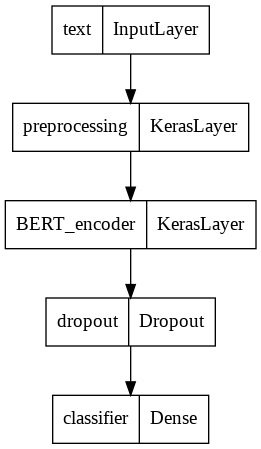

In [ ]:
tf.keras.utils.plot_model(classifier_model)

### 训练模型

#### 损失函数

In [ ]:
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# metrics = tf.metrics.BinaryAccuracy()
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

#### 优化器

In [ ]:
# epochs = 2
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# init_lr = 3e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                       num_train_steps=num_train_steps,
#                       num_warmup_steps=num_warmup_steps,
#                       optimizer_type='adamw')

In [ ]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

#### 编译

In [ ]:
classifier_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

#### 拟合

In [ ]:
history = classifier_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 12s 202ms/step - loss: 0.8899 - accuracy: 0.5071 - precision: 0.5081 - recall: 0.4482
Epoch 2/5
35/35 [==============================] - 7s 207ms/step - loss: 0.7096 - accuracy: 0.5321 - precision: 0.5312 - recall: 0.5464
Epoch 3/5
35/35 [==============================] - 7s 205ms/step - loss: 0.7749 - accuracy: 0.5009 - precision: 0.5008 - recall: 0.5500
Epoch 4/5
35/35 [==============================] - 7s 204ms/step - loss: 0.5168 - accuracy: 0.7518 - precision: 0.7573 - recall: 0.7411
Epoch 5/5
35/35 [==============================] - 7s 204ms/step - loss: 0.1612 - accuracy: 0.9652 - precision: 0.9780 - recall: 0.9518


### 评估模型

In [ ]:
loss, accuracy, precision, recall = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

12/12 [==============================] - 2s 104ms/step - loss: 0.2488 - accuracy: 0.9278 - precision: 0.9651 - recall: 0.8877
Loss: 0.24882695078849792
Accuracy: 0.9278075098991394
Precision: 0.9651162624359131
Recall: 0.8877005577087402


In [ ]:
y_predicted = classifier_model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,

### 绘图

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[181,   6],
       [ 21, 166]])

Text(33.0, 0.5, 'Truth')

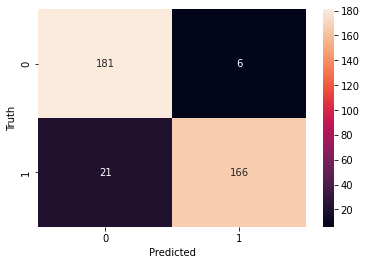

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       187
           1       0.97      0.89      0.92       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [ ]:
# history_dict = history.history
# print(history_dict.keys())

# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)
# fig = plt.figure(figsize=(10, 6))
# fig.tight_layout()

# plt.subplot(2, 1, 1)
# # r is for "solid red line"
# plt.plot(epochs, loss, 'r', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# # plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

### 导出模型

In [ ]:
!mkdir -p saved_model

In [ ]:
dataset_name = 'sms'
saved_model_path = '/content/gdrive/MyDrive/SpamDetection/saved_model/{}_bert_model_en'.format(dataset_name.replace('/', '_'))

In [ ]:
classifier_model.save(saved_model_path, include_optimizer=False)

### 样本预测

In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.",
    "SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",
    "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.",
    "I HAVE A DATE ON SUNDAY WITH WILL!!",
]

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : spam: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_results = reloaded_model.predict(reviews).flatten()
print(reloaded_results)
reloaded_results = np.where(y_predicted > 0.5, 1, 0)

AttributeError: ignored

In [ ]:
print_my_examples(reviews, reloaded_model(tf.constant(reviews)))

input: Enter a chance to win $5000, hurry up, offer valid until march 31, 2021 : spam: 0.185306
input: You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99 : spam: 0.964094
input: it to 80488. Your 500 free text messages are valid until 31 December 2005. : spam: 0.983871
input: Hey Sam, Are you coming for a cricket game tomorrow : spam: 0.186421
input: Why don't you wait 'til at least wednesday to see if you get your . : spam: 0.186671
input: WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only. : spam: 0.992766
input: SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info : spam: 0.990383
input: I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today

In [ ]:
print('Results from the saved model:')
print_my_examples(reviews, reloaded_results)